In [45]:
# 导入相关包
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as tdst
# 预处理
import torchvision.transforms as transforms
import torch.optim as optim

# 模型架构可视化
from torchsummary import summary

In [46]:
# 显示一张原图
img = plt.imread('data/img_align_celeba/000008.jpg')

In [47]:
img.shape

(218, 178, 3)

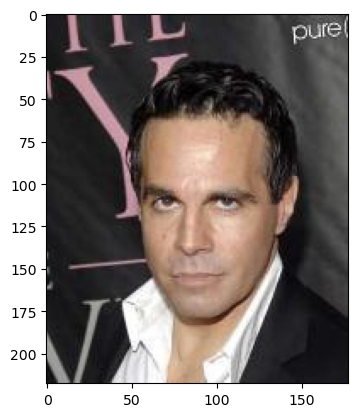

In [48]:
plt.imshow(img)

In [49]:
# 导入数据

In [50]:
img_size = 64

In [51]:
img_preprocess = transforms.Compose([
    # 缩放，宽度64，高度自适应
    transforms.Resize(img_size),
    # 中心裁剪为 64 x 64 的正方形
    transforms.CenterCrop(img_size),
    # PIL图像转为tensor，归一化到[0,1]：Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.ToTensor(),
    # 规范化至 [-1,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),


])

In [52]:
# 从文件夹读取图片
dataset = tdst.ImageFolder(root='./data/',transform=img_preprocess)

In [53]:
# 查看图片大小
len(dataset)

12324

In [54]:
# 查看最小值和最大值
dataset[0][0].max(),dataset[0][0].min()

(tensor(1.), tensor(-1.))

In [55]:
BATCH_SIZE = 128

In [56]:
# 训练的加载器
dataloader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE,shuffle=True)

In [57]:
# 查看批次数量
len(dataloader)

97

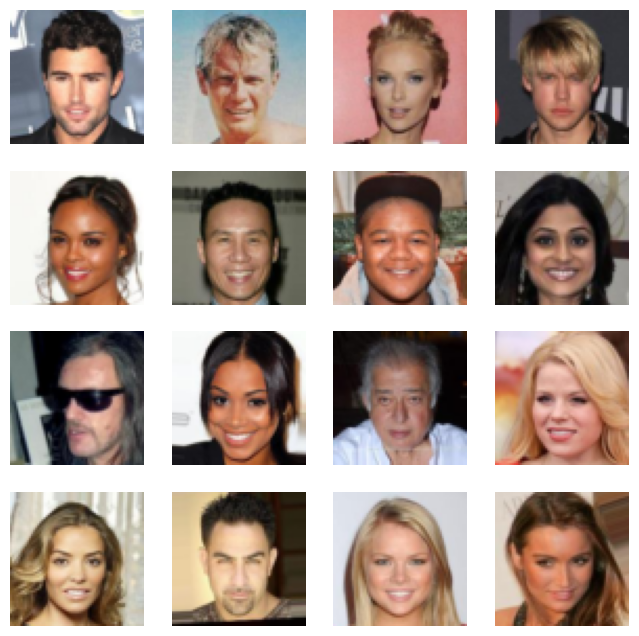

In [58]:
# 显示几张
for x in dataloader:
    # 设置画布大小
    fig = plt.figure(figsize=(8,8))
    
    for i in range(16):
        # 图片位置
        plt.subplot(4,4,i+1)
        # 转为numpy
        img = x[0][i].numpy()
        # 调整 通道顺序为PIL格式
        img =  np.transpose(img,(1,2,0))
        # 先转到[0,1]，再乘以255
        img =(img + 1 )/ 2 * 255
        # 取整
        img = img.astype('int')
        # 显示
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    break

In [59]:
# 显示网络架构

<img src="./data/model_arc_1.png" width = "1200"/>

In [60]:
# G生成网络

In [61]:
import torch.nn as nn

In [62]:
class G_model(nn.Module):
    def __init__(self):
        super(G_model,self).__init__()
        self.main = nn.Sequential(
            # input: 100 x 1 x 
            # !!! stride and padding
            # output: 512 x 4 x 4
            nn.ConvTranspose2d(in_channels=100,out_channels=512,kernel_size=4,stride=1,padding=0,bias=False),
            # BN
            nn.BatchNorm2d(num_features=512),
            # Relu
            nn.ReLU(inplace=True),
            
            
            # input: 512 x 4 x4 
            # output : 256 x 8 x 8
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
            # BN
            nn.BatchNorm2d(num_features=256),
            # Relu
            nn.ReLU(inplace=True),
            
            # input: 256 x 8 x8
            # output: 128 x 16 x 16
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            
            # input : 128 x 16 x 16 
            # output: 64 x 32 x 32
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            # input: 64 x 32 x 32
            # output: 3 x 64 x 64
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1,bias=False),
            # tanh
            nn.Tanh()
            
        
        )
    
    def forward(self,input):
        return self.main(input)

In [63]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
device

device(type='cuda', index=0)

In [65]:
# 实例化
G_model = G_model().to(device)

In [66]:
print(G_model)

G_model(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [67]:
# 查看架构
summary(G_model,(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [68]:
# 构建一个大小为100x1x1的随机张量（CHW）
fixed_noise = torch.randn(1, 100, 1, 1, device=device)
fake_imgs = G_model(fixed_noise)
fake_imgs_np = fake_imgs.detach().cpu().numpy()

In [69]:
fake_imgs_np.shape

(1, 3, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


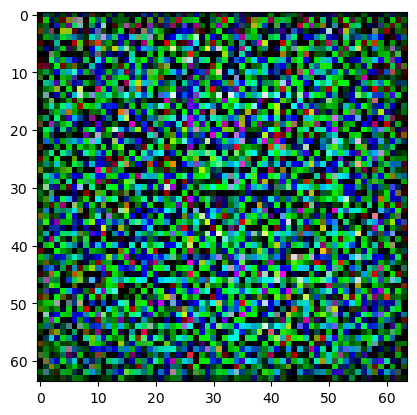

In [70]:
plt.imshow(np.transpose(fake_imgs_np[0],(1,2,0)))

<img src="./data/model_arc_1.png" width = "1200"/>

In [71]:
#定义D判别网络

In [72]:
class D_model(nn.Module):
    def __init__(self):
        super(D_model,self).__init__()
        self.main = nn.Sequential(
            # input： 3 x 64 x 64
            # output: 64 x 32 x 32
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
            # Relu
            nn.LeakyReLU(0.2,inplace=True),
            
            # input: 64 x 32 x 32
            # output: 128 x 16 x 16
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
            # BN
            nn.BatchNorm2d(128),
            # relu
            nn.LeakyReLU(0.2,inplace=True),
            
            
            # input: 128 x 16 x 16
            # output : 256 x 8 x 8
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            
            # input : 256 x 8 x 8
            # output : 512 x 4 x 4
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),
            
            #  拉直：8192 (512 x 4 x 4)
            nn.Flatten(),
            # 变成 1
            nn.Linear(8192,1),
            # sigmoid
            nn.Sigmoid()
            
        )
    
    def forward(self,input):
        return self.main(input)

In [73]:
# 实例化
D_model = D_model().to(device)

In [74]:
# 查看网络架构
summary(D_model,(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
          Flatten-12                 [-1, 8192]               0
           Linear-13                    [-1, 1]           8,193
          Sigmoid-14                   

In [75]:
# 将生成器产生的虚假图片输入D判别器

In [76]:
output = D_model(fake_imgs)

In [77]:
output

tensor([[0.6999]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [78]:
# 去除多余维度
output.view(-1)

tensor([0.6999], device='cuda:0', grad_fn=<ViewBackward0>)

In [79]:
# loss损失函数
loss_fun = nn.BCELoss()

In [80]:
# 优化器
D_optimizer = optim.Adam(D_model.parameters(),lr=0.0002,betas=(0.5, 0.999))
G_optimizer = optim.Adam(G_model.parameters(),lr=0.0002,betas=(0.5, 0.999))


In [81]:
# 开始训练

In [82]:
import time

In [ ]:
# 训练100个epoch
EPOCH_NUM = 100

for epoch in range(EPOCH_NUM):
    # 获取批次图像
    start_time = time.time()
    for i,data in enumerate(dataloader):
        #----------------------训练D：真实数据标记为1------------------------
        # ！！！每次update前清空梯度
        D_model.zero_grad()
        # 获取数据 （data[0]是图片，data[1]是类别）
        imgs_batch = data[0].to(device)
        # batch_size，最后不可以用BATCH_SIZE，因为数据集数量可能不能被BATCH_SIZE整除
        b_size = imgs_batch.size(0)
        # 计算输出
        output = D_model(imgs_batch).view(-1)
        # 构建全1向量label
        ones_label = torch.full((b_size,),1,dtype=torch.float,device=device)
        # 计算loss
        d_loss_real = loss_fun(output,ones_label)
        # 计算梯度
        d_loss_real.backward()
        # 反向传播优化
        D_optimizer.step()
        
        # -------------------训练D：假数据标记为0-------------------------------
        # 清除梯度
        D_model.zero_grad()
        # 构建随机张量
        noise_tensor = torch.randn(b_size,100,1,1,device=device)
        # 生成假的图片
        generated_imgs = G_model(noise_tensor)
        # 假图片的输出，此时不需要训练G，可以detach
        output = D_model(generated_imgs.detach()).view(-1)
        
        # 构建全0向量
        zeros_label = torch.full((b_size,),0,dtype=torch.float,device=device)
        # 计算loss
        d_loss_fake = loss_fun(output,zeros_label)
        # 计算梯度
        d_loss_fake.backward()
        # 优化
        D_optimizer.step()
        
        
        # ----------------------训练G 网络：假数据标记为1--------------------
        # 清除梯度
        G_model.zero_grad()
        # 随机张量
        noise_tensor = torch.randn(b_size,100,1,1,device=device)
        # 生成假的图片
        generated_imgs = G_model(noise_tensor)
        # !!!!!!!!!!!!!! 假图片的输出，这里不可以detach，否则学习不到
        output = D_model(generated_imgs).view(-1)
        
        # 构建全1向量
        ones_label = torch.full((b_size,),1,dtype=torch.float,device=device)
        # 计算loss
        g_loss = loss_fun(output,ones_label)
        # 计算梯度
        g_loss.backward()
        # 优化
        G_optimizer.step()
        
    
    # 打印训练时间
    print('第{}个epoch执行时间:{}s'.format(epoch,time.time()-start_time))
    # 每一个epoch输出结果
    # 用no_grad表示不跟踪梯度
    with torch.no_grad():
        # 生成16 个随机张量
        fixed_noise = torch.randn(16, 100, 1, 1, device=device)
        # 生成的图片
        fake_imgs = G_model(fixed_noise).detach().cpu().numpy()
        # 画布大小
        fig = plt.figure(figsize=(10, 10))
        for i in range(fake_imgs.shape[0]):
            plt.subplot(4, 4, i+1)
            img =  np.transpose(fake_imgs[i],(1,2,0))  # 变换通道顺序为(H,W,C)
            img =(img+1 )/ 2 * 255
            img = img.astype('int')
            plt.imshow(img)
            plt.axis('off')
        plt.show()
        
        
        
        
        

In [ ]:
# 保存模型
torch.save(G_model.state_dict(), './models/g_model.pt')